In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os
import glob

import zipfile

zip_path = '/content/drive/MyDrive/img_align_celeba.zip'
extract_to = '/content/img_celeba'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Extracted from Google Drive")

✅ Extracted from Google Drive


1. XỬ LÍ DATA


In [ ]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(), ## Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #Biến [0,1] thành [-1,1]
])

dataset_path = '/content/img_celeba/img_align_celeba'  # Make sure this path is correct in Colab
dataset = CelebADataset(root_dir=dataset_path, transform=transform)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

print(f"Total images loaded: {len(dataset)}")


Total images loaded: 202599


In [ ]:
# === Describe Dataset ===
sample = next(iter(dataloader))
print(f"🔍 Image tensor shape: {sample.shape}")  # (batch_size, channels, height, width)
print(f"📏 Single image size: {sample[0].shape}")
print(f"📺 Channels: {sample.shape[1]}")

🔍 Image tensor shape: torch.Size([128, 3, 64, 64])
📏 Single image size: torch.Size([3, 64, 64])
📺 Channels: 3


In [ ]:
# === Compute Mean and Std (on a small sample for speed) ===
subset = torch.cat([sample[i].unsqueeze(0) for i in range(min(100, len(sample)))], dim=0)
mean = subset.mean(dim=(0, 2, 3))
std = subset.std(dim=(0, 2, 3))

print(f"📊 Mean (approx): {mean}")
print(f"📊 Std (approx): {std}")

📊 Mean (approx): tensor([ 0.0061, -0.1521, -0.2503])
📊 Std (approx): tensor([0.6126, 0.5682, 0.5613])


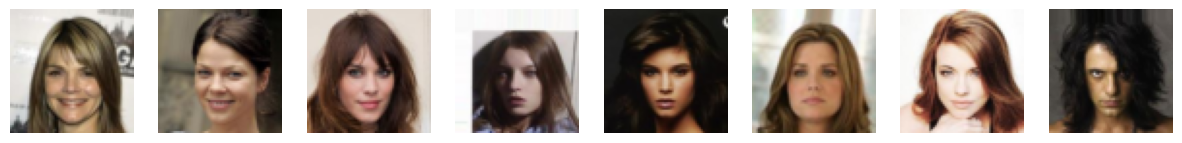

In [ ]:
def show_images(images, num=8):
    images = images[:num]
    images = images * 0.5 + 0.5  # Unnormalize
    np_images = images.numpy()
    fig, axes = plt.subplots(1, num, figsize=(15, 3))
    for i in range(num):
        axes[i].imshow(np.transpose(np_images[i], (1, 2, 0)))
        axes[i].axis('off')
    plt.show()

show_images(sample)

2. ĐỊNH NGHĨA 2 MODELS:

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh() #pixel có giá trị [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:


class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d, features_d * 2, 4, 2, 1),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features_d * 8, 1, 4, 1, 0),
            nn.Sigmoid() #Đưa về xác suất (0, 1)
        )

    def forward(self, x):
        return self.disc(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

print("📦 Generator model:")
summary(generator, (100, 1, 1))

print("\n🛡️ Discriminator model:")
summary(discriminator, (3, 64, 64))

📦 Generator model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14

3. KHỞI TẠO 2 MODELS

In [ ]:

z_dim = 100
criterion = nn.BCELoss() #xác xuất nhị phân
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) #ổn định gradient, decay rate
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

def generate_and_save_images(model, epoch, path="/content/GANimg", num_images=16):
    os.makedirs(path, exist_ok=True)
    model.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, z_dim, 1, 1).to(device)
        fake_images = model(noise).cpu()
        grid = utils.make_grid(fake_images, nrow=4, normalize=True)
        utils.save_image(grid, f"{path}/epoch_{epoch}.png")
        plt.figure(figsize=(8,8))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis('off')
        plt.title(f"Epoch {epoch}")
        plt.show()


4. HUẤN LUYỆN

Epoch 0 / 22 | D Loss: 1.0738 | G Loss: 1.3102


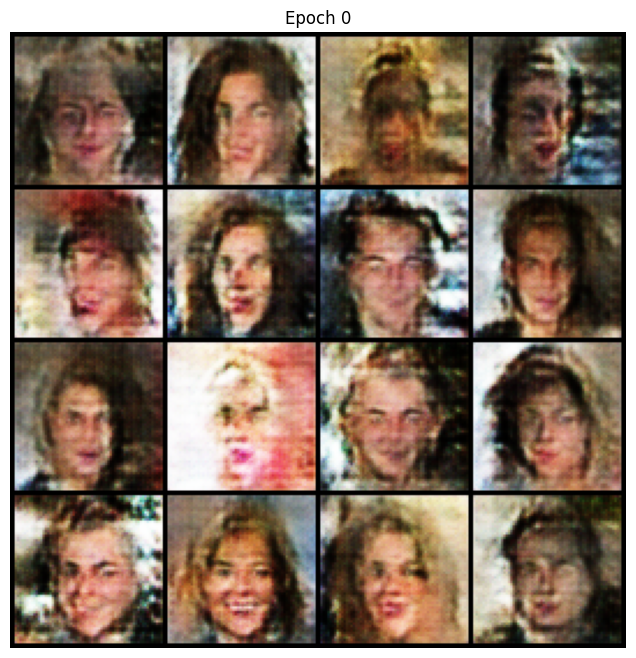

Epoch 1 / 22 | D Loss: 0.9934 | G Loss: 1.3119


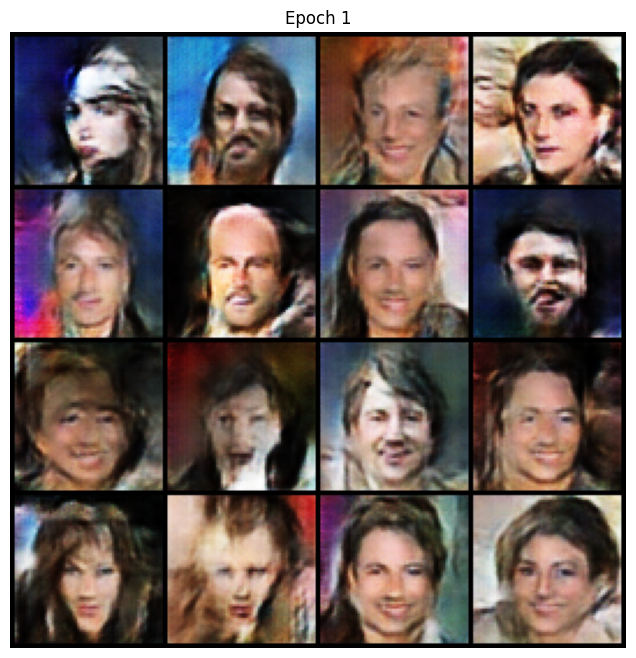

Epoch 2 / 22 | D Loss: 1.1150 | G Loss: 0.9906


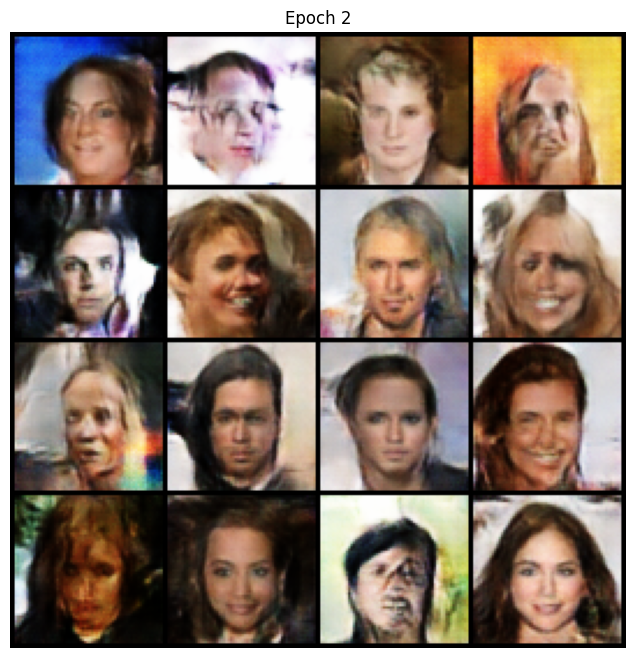

Epoch 3 / 22 | D Loss: 0.9205 | G Loss: 1.4371


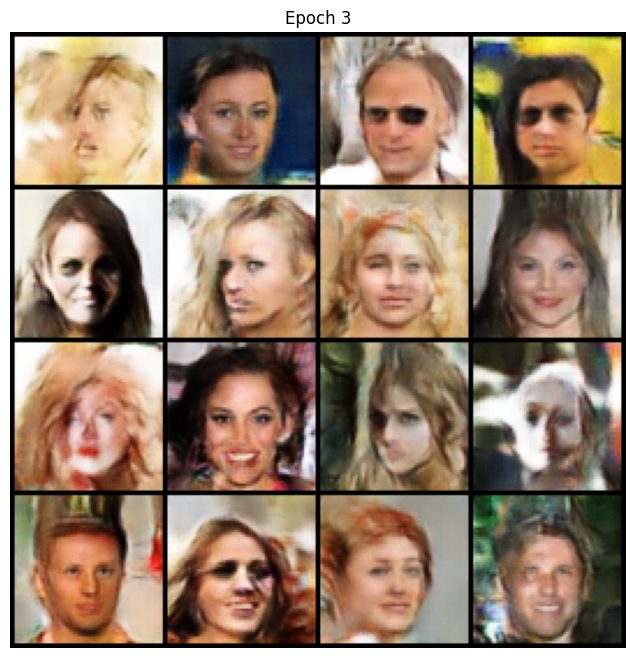

In [ ]:
epochs = 22
for epoch in range(epochs):
    for batch in dataloader:
        batch = batch.to(device)
        batch_size = batch.size(0)

        # Smoothed Labels
        real_labels = torch.full((batch_size, 1), 0.9).to(device) #D không quá tự tin
        fake_labels = torch.full((batch_size, 1), 0.1).to(device) #Nhiễu nhẹ

        # Train Discriminator
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_imgs = generator(noise) #3, 64, 64

        real_preds = discriminator(batch).view(-1, 1) #reshape về dạng [batch_size, 1]
        fake_preds = discriminator(fake_imgs.detach()).view(-1, 1) #ngắt gradient
        loss_d = criterion(real_preds, real_labels) + criterion(fake_preds, fake_labels)

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        preds = discriminator(fake_imgs).view(-1, 1)
        loss_g = criterion(preds, real_labels)

        optimizer_g.zero_grad()
        loss_g.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0) #tránh gradient explode

        optimizer_g.step()

    print(f"Epoch {epoch} / {epochs} | D Loss: {loss_d.item():.4f} | G Loss: {loss_g.item():.4f}")
    generate_and_save_images(generator, epoch)


In [ ]:
import os
import torch

# Create save directory in Google Drive
model_save_dir = "/content/drive/MyDrive/gan_models"
os.makedirs(model_save_dir, exist_ok=True)

epoch = 21
# Save model weights (replace `epoch` with your actual epoch number)
torch.save(generator.state_dict(), os.path.join(model_save_dir, f"dcgan_generator_epoch_{epoch}.pth"))
torch.save(discriminator.state_dict(), os.path.join(model_save_dir, f"dcgan_discriminator_epoch_{epoch}.pth"))

print(f"✅ Saved models for epoch {epoch} to {model_save_dir}")
